# Convolutionnal Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [53]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [54]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [55]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

max_clean = np.max(np.abs(stft_clean_dataset_real))
max_white = np.max(np.abs(stft_white_dataset_real))
stft_clean_dataset_real = np.array(stft_clean_dataset_real)
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(10659, 3, 513) (10659, 3, 513) (10659, 3, 513) (10659, 3, 513)


# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [56]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s*100000000)

In [57]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x1 = tf.keras.layers.Dense(10, activation='relu')(inputs)
    x4 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x1)
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(x4)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model
g = generator(stft_white_dataset_real.shape)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 3, 513)]          0         
_________________________________________________________________
dense_45 (Dense)             (None, 3, 10)             5140      
_________________________________________________________________
dense_46 (Dense)             (None, 3, 513)            5643      
_________________________________________________________________
dense_47 (Dense)             (None, 3, 513)            263682    
Total params: 274,465
Trainable params: 274,465
Non-trainable params: 0
_________________________________________________________________


Take care, the distance between the raw audio might be 'too continuous' to use a classical distance function. Maybe, use the distance function on the STFT's, or another loss function on the raw audio.

667/667 [==============================] - 3s 4ms/step - loss: 10971.4648 - accuracy: 0.4053
Loss: 0.18934815801240112
667/667 [==============================] - 3s 4ms/step - loss: 10195.3057 - accuracy: 0.4365
Loss: 0.1751772695342779
667/667 [==============================] - 3s 4ms/step - loss: 9641.4170 - accuracy: 0.4514
Loss: 0.16409074538514076
667/667 [==============================] - 3s 5ms/step - loss: 9227.7393 - accuracy: 0.4642
Loss: 0.15580938469234312
667/667 [==============================] - 3s 4ms/step - loss: 8901.2871 - accuracy: 0.4743
Loss: 0.1489760146735511


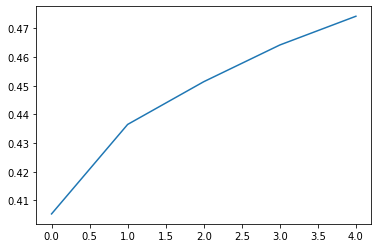

In [59]:
accuracies = []
for _ in range(5):
    accuracies.append(g.fit(stft_white_dataset_real, stft_clean_dataset_real, batch_size=16, verbose=1).history["accuracy"])
    print("Loss:", evaluate_generator(g, stft_white_dataset_real, stft_clean_dataset_real))
plt.plot(accuracies)

In [ ]:
inputs = []
outputs = []
for i in range(10):
    x = np.reshape(white_dataset[i, :].T, (1, white_dataset.shape[1]))
    y = np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
    t, y1 = istft(np.reshape(g.predict(y).T, (513, 3))+np.imag(stft_white_dataset_imag[i]).T)
    x2 = np.reshape(x.T, (clean_dataset.shape[1],))
    y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
    inputs.append(x2)
    outputs.append(y2)

a = np.concatenate(inputs)
b = np.concatenate(outputs)

c, t, axx = stft(a, fs=samplerate, nperseg=nperseg)
c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
displaySpectrogram(axx)
plt.show()
displaySpectrogram(bxx)
plt.show()

In [8]:
Audio(a, rate=samplerate)

In [9]:
Audio(b, rate=samplerate)